In [160]:
%load_ext autoreload

import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.optimize import minimize

import pyOptLE as optle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [292]:
%autoreload

In [303]:
generate = False
n = 1000  # number of synthetic trajectories
N = 100   # n. time steps per trajectory

do_undebiased = False

# User needs to provide dt!
dt = 0.1
T = 300

# data from "real" simulation
filenames = ['data_10ala/decaa_abf_500traj', 'data_10ala/decaa_abmd_500traj',
             'data_10ala/decaa_nobias_500traj', 'data_10ala/decaa_smd_500traj']

auto_bounds = True # If not, specify grid boundaries manually
# qmin_user = 11
# qmax_user = 34

n_knots = 30

In [304]:
# Load trajectory or generate synthetic data in 1D overdamped simulation

if generate:
    D = 0.5
    R = 0.00198720425864 # kcal/mol
    RT = R * T
    beta = 1 / RT
#     V = optle.V_harm
#     nablaV = optle.nablaV_harm
    V = optle.V_dblwell
    nablaV = optle.nablaV_dblwell
    q = optle.overdamped_Langevin(n, N, dt, beta, D, nablaV)
    f = np.zeros_like(q)
else:
    q, f = optle.load_traj(filenames)

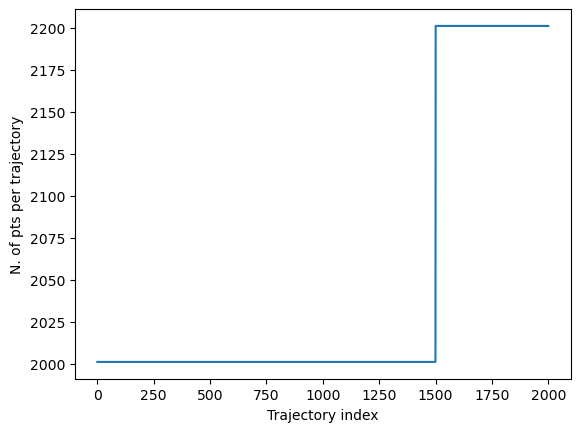

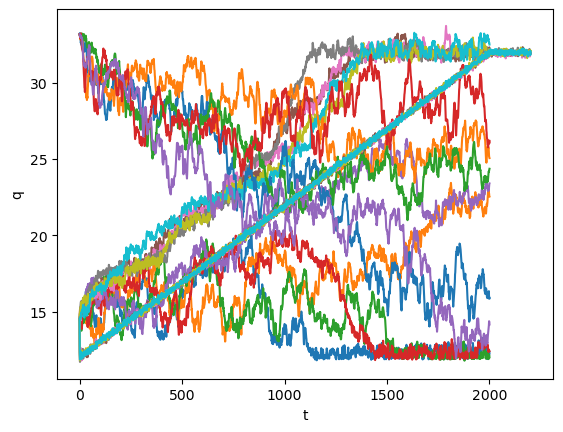

In [305]:
plot_samples = True
plot_traj = True
n_plots = 20

if plot_samples:
    plt.plot([qi.shape[0] for qi in q])
    plt.xlabel('Trajectory index')
    plt.ylabel('N. of pts per trajectory')

if plot_traj:
    plt.figure()
    stride = len(q) // n_plots
    if stride == 0:
        stride = 1
    for qi in q[::stride]:
        plt.plot(qi)
    plt.xlabel('t')
    plt.ylabel('q')

In [306]:
# Create grid and initial parameter set

epsilon = 1e-10
qmin_data = min([np.min(qi) for qi in q]) - epsilon
qmax_data = max([np.max(qi) for qi in q]) + epsilon

if auto_bounds:
    # Add margin for floating-point precision
    qmin = qmin_data
    qmax = qmax_data
else:
    assert qmin_user <= qmin_data, '%f > %f' % (qmin_user, qmin_data)
    assert qmax_user >= qmax_data, '%f < %f' % (qmax_user, qmax_data)
    qmin = qmin_user
    qmax = qmax_user


knots = np.linspace(qmin, qmax, n_knots)

# Initial guess for the parameters: zero free energy gradient, constant D = 1
initial_params = np.concatenate((np.zeros(n_knots), np.zeros(n_knots) + 1.))

In [307]:
# Optimize with debiasing

result, hist = optle.optimize_model(initial_params, knots, q, f, dt, T = T)

Pre-processing trajectories...
Done in 0.150 seconds
Compiling and running objective function...
Obj = 39460655.632
Compiled and ran in 0.039 seconds
Obj = 39460655.632
Runs in 0.037 seconds
Step          0    Parameter mean sq.       0.38
Step        100    Parameter mean sq.       5.91
Step        200    Parameter mean sq.       7.80
Step        300    Parameter mean sq.       8.05
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Optimization converged in 385 steps, 16.870 seconds


In [308]:
# Re-optimize without debiasing

if do_undebiased:
    result_nb, hist_nb = optle.optimize_model(initial_params, knots, q, f = None, dt = dt, T = T)

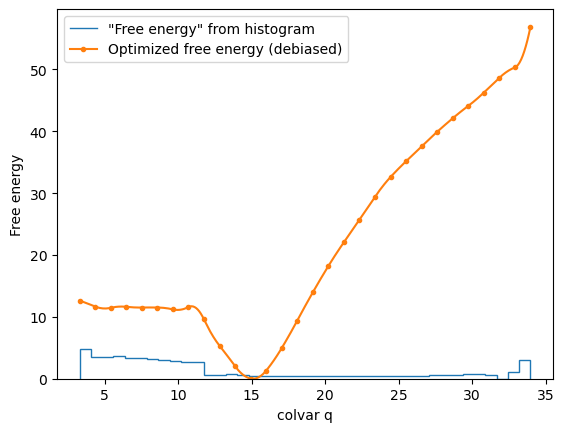

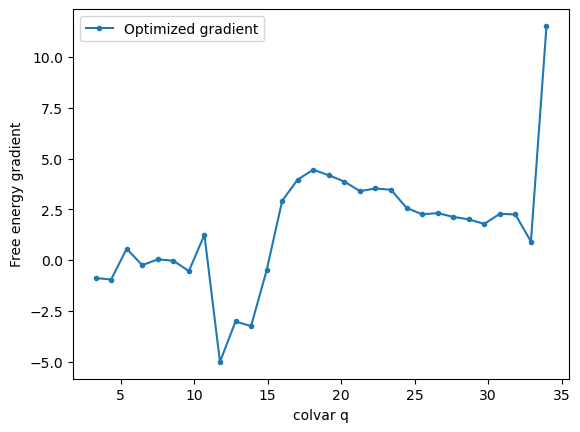

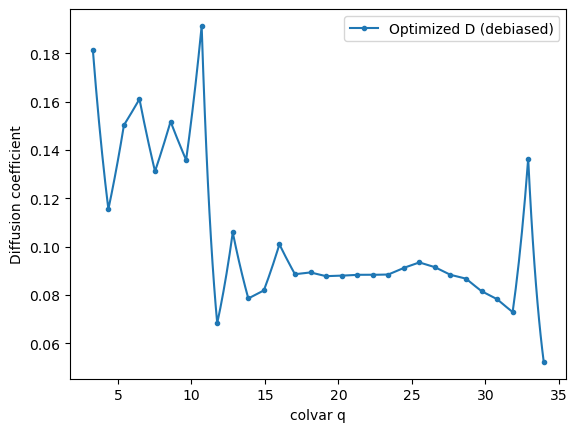

In [309]:
# Smoother interpolation for plotting
interp_factor = 10

# Fencepost theorem aplied forward and then backward
n_discr_points = interp_factor * (len(knots) - 1) + 1
x = np.linspace(qmin, qmax, n_discr_points)

optimized_params = result.x
optimized_G = optimized_params[:n_knots]
optimized_logD = optimized_params[n_knots:]
# Integral of linear interpolation
predicted = optle.piecewise_linear_int(x, knots, optimized_G)

if do_undebiased:
    optimized_params_nb = result_nb.x
    optimized_G_nb = optimized_params_nb[:n_knots]
    optimized_logD_nb = optimized_params_nb[n_knots:]
    predicted_nb = optle.piecewise_linear_int(x, knots, optimized_G_nb)


# Plot the original data and the optimized spline
import matplotlib.pyplot as plt

counts, bins = np.histogram(np.concatenate(q), bins=40)
# FE = -RT * np.log(counts)
# FE -= np.min(FE)
# plt.stairs(FE, bins, label='FE from histogram')
R = 0.00198720425864 # kcal/mol
RT = R * T
plt.stairs(-RT*(np.log(counts)-np.max(np.log(counts))), bins, label='\"Free energy\" from histogram')

plt.plot(x, predicted, label='Optimized free energy (debiased)', marker='.', markevery=interp_factor)
if do_undebiased:
    plt.plot(x, predicted_nb, label='Optimized free energy (not debiased)', marker='.', markevery=interp_factor)

plt.xlabel('colvar q')
plt.ylabel('Free energy')

if generate:
    plt.plot(x, V(x) - np.min(V(x)), label='True potential')

# Ad hoc bc we know this is a double well
# plt.plot(x, optle.V_dblwell(x) - np.min(optle.V_dblwell(x)), label='Ideal double well')
plt.legend()


plot_gradient = True
if plot_gradient:
    plt.figure()
    plt.plot(knots, optimized_G, label='Optimized gradient', marker='.')
    if generate:
        plt.plot(x, nablaV(x), label='True gradient')
    plt.xlabel('colvar q')
    plt.ylabel('Free energy gradient')
    plt.legend()


plt.figure()
plt.plot(x, np.exp(np.interp(x, knots, optimized_logD)), label='Optimized D (debiased)',
         marker='.', markevery=interp_factor)
if do_undebiased:
    plt.plot(x, np.exp(np.interp(x, knots, optimized_logD_nb)), label='Optimized D (not debiased)',
             marker='.', markevery=interp_factor)

if generate:
    plt.plot([qmin, qmax], [D, D], label='True D')
plt.xlabel('colvar q')
plt.ylabel('Diffusion coefficient')
plt.legend()